# Market Basket Analysis using Apriori Algorithm (Daniel Pak and Harry Wei)

## Import the Occupancy Dataset

The dataset we decided to choose to perform market basket analysis was occupancy of a room (classification) given different measurements. We decided to choose this dataset because we previously used it for the Logistic Regression Assignment, and this dataset is easy to interpret, with logical association rules. This dataset we selected is from a 1 week period in 2/4/15 to 2/10/15.

 Occupancy is encoded as a binary variable, so we had to encode everything else. The only feature we decided to remove was humidity ratio as we felt this was unnecessary since humidity was already present in the dataset. To differentiate the time and date independently from the date feature, we it into 2 separate columns, where day of the week is the day of the data recording and time is the hour of the data recording.

In [ ]:
import requests
import zipfile
from urllib.request import urlopen
from io import BytesIO
import pandas as pd
import math
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import StrMethodFormatter
import seaborn
from sklearn.model_selection import train_test_split
from mlxtend.frequent_patterns import apriori

"""
date (timestamp and date) -- Input Variable
Temperature -- Input Variable
Humidity -- Input Variable
Light -- Input Variable
CO2 -- Input Variable
HumidityRatio -- Input Variable
Occupancy -- Output Variable (binary classification)
"""
#source to import multiple files from online zip file: https://github.com/zooniverse/planet-four/issues/185
zip_file_url = 'http://archive.ics.uci.edu/ml/machine-learning-databases/00357/occupancy_data.zip'
remote_zip_file = urlopen(zip_file_url)
zipinmemory = BytesIO(remote_zip_file.read())
zip_file = zipfile.ZipFile(zipinmemory)
df = pd.read_csv(zip_file.open(zip_file.namelist()[2])) #['datatest.txt', 'datatest2.txt', 'datatraining.txt'], shapes of 2665, 9752, 8143 
# 2/2/15 to 2/4/15 (first file)
# 2/11/15 to 2/18/15 (second file)
# 2/4/15 to 2/10/15 (third file)

# Splitting time stamp string into date and time and append to the beginning of dataframe
date = [d[0] for d in df["date"].str.split()]
time = [d[1] for d in df["date"].str.split()]
date = [d.split("-")[-1] for d in date]
time = [t.split(":")[0] for t in time]

df.insert(0,'Day of Week', date)
df.insert(1,'Time', time)
df = df.drop(["date"], axis=1)

display(df.head(5))
print(f"Date = {df['Day of Week'].unique()}")
print(f"Shape of dataframe = {df.shape}")

,Day of Week,Time,Temperature,Humidity,Light,CO2,HumidityRatio,Occupancy
1,04,17,23.18,27.2720,426.0,721.25,0.004793,1
2,04,17,23.15,27.2675,429.5,714.00,0.004783,1
3,04,17,23.15,27.2450,426.0,713.50,0.004779,1
4,04,17,23.15,27.2000,426.0,708.25,0.004772,1
5,04,17,23.10,27.2000,426.0,704.50,0.004757,1


Date = ['04' '05' '06' '07' '08' '09' '10']
Shape of dataframe = (8143, 8)


### Distribution of the Occupancy dataset

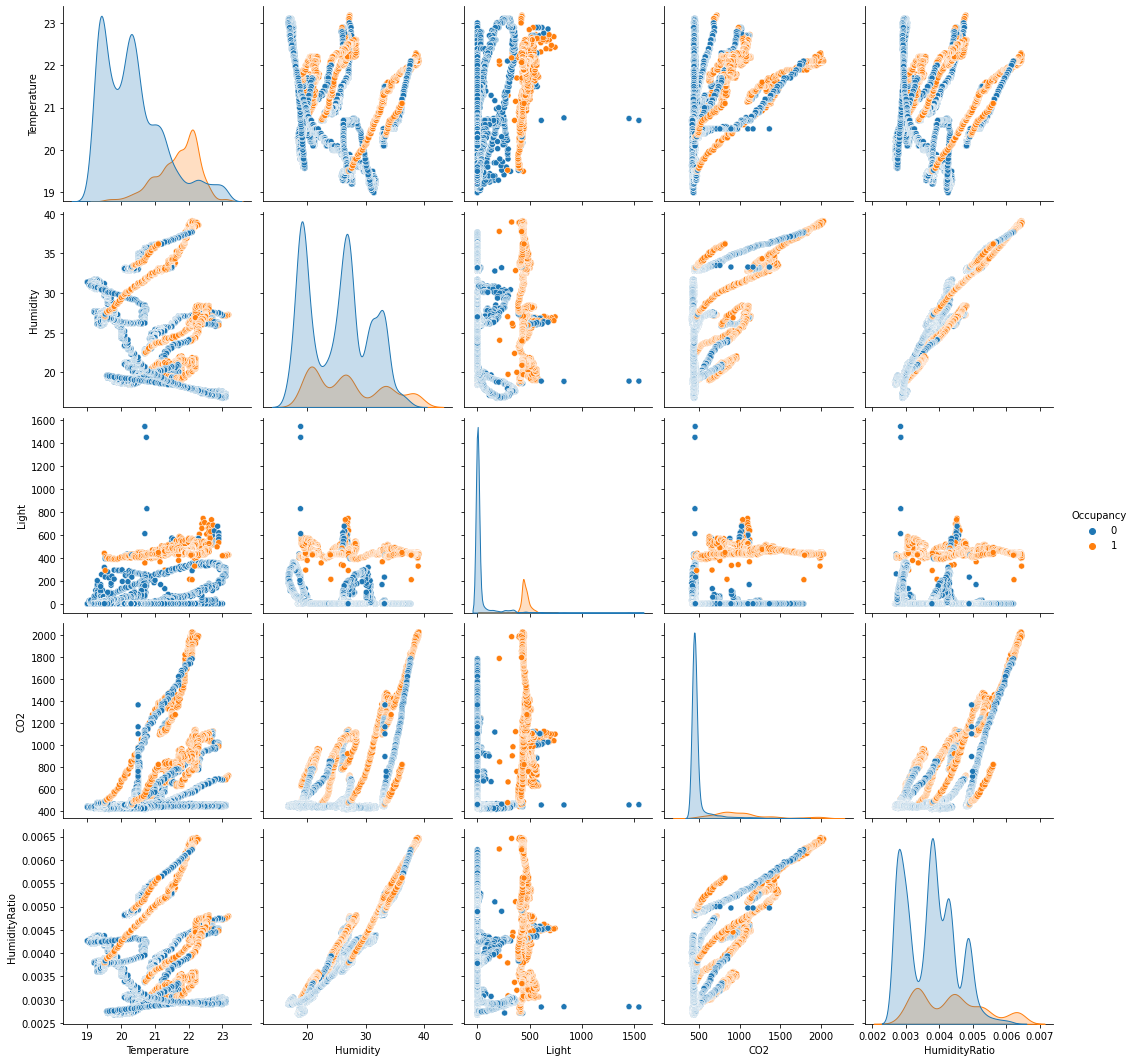

In [ ]:
import seaborn 
seaborn.pairplot(df, hue = "Occupancy", kind='scatter', diag_kind='kde', height=3, 
                 aspect=1, corner=False, dropna=False, plot_kws=None, diag_kws=None, grid_kws=None, size=None)

Looking at the scatter matrix of the dataset, it is shown that most of the time the office is unoccupied. Looking at the diagonal, there is a clear distinction for light and whether the office is occupied or not, based off the 2 distinct peaks. CO2 is also somewhat distinct, with lower CO2 concentration occuring when the office is unoccupied. Looking at temperature, there does appear to be a boundary even though the dataset seems to intersect, but it does tell us that lower temperatures have more of a chance of being unoccupied, and higher temperatures have more of a chance of being occupied.

## Encoding Our Features

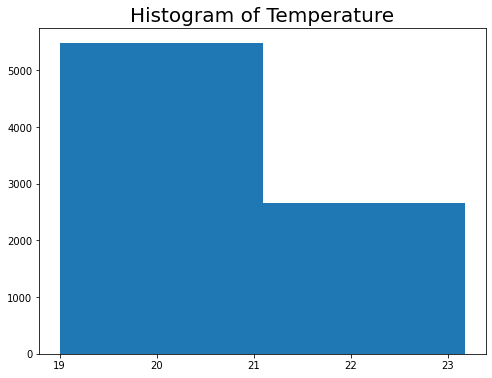

[19.   21.09 23.18]


In [ ]:
plt.figure(figsize=(8,6))
n, bins, patches = plt.hist(df['Temperature'],bins = 2)
plt.title("Histogram of Temperature", fontsize=20)
plt.show()
#print(f"Temperature = {df['Temperature'].unique()}")
print(bins)

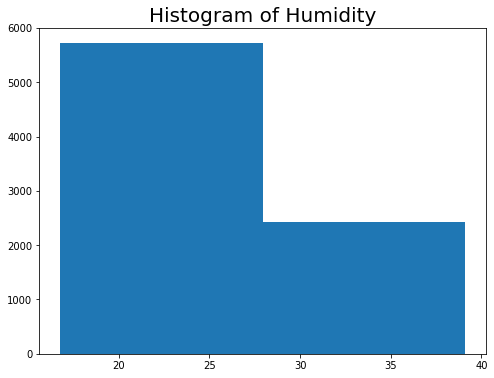

[16.745   27.93125 39.1175 ]


In [ ]:
plt.figure(figsize=(8,6))
n, bins, patches = plt.hist(df['Humidity'],bins = 2)
plt.title("Histogram of Humidity", fontsize=20)
plt.show()
print(bins)

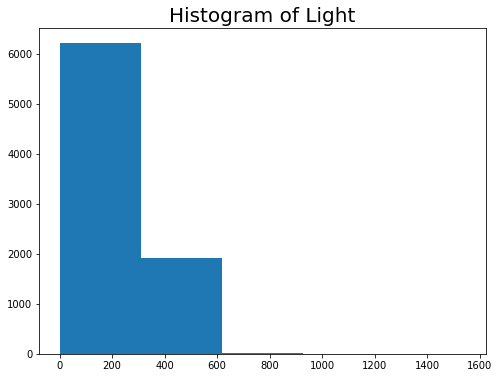

[   0.          309.26666667  618.53333333  927.8        1237.06666667
 1546.33333333]
76.23725899545622


In [ ]:
plt.figure(figsize=(8,6))
n, bins, patches = plt.hist(df['Light'],bins = 5)
plt.title("Histogram of Light", fontsize=20)
plt.show()
print(bins)
print(100*n[0]/np.sum(n))

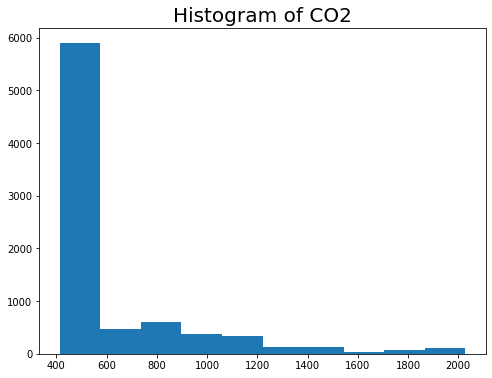

[ 412.75   574.325  735.9    897.475 1059.05  1220.625 1382.2   1543.775
 1705.35  1866.925 2028.5  ]
72.38118629497728


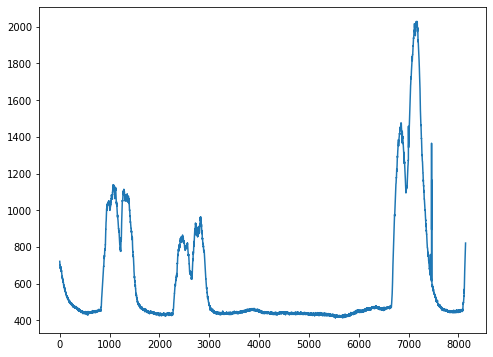

In [ ]:
plt.figure(figsize=(8,6))
n, bins, patches = plt.hist(df['CO2'],bins = 10)
plt.title("Histogram of CO2", fontsize=20)
plt.show()
print(bins)
print(100*n[0]/np.sum(n))

plt.figure(figsize=(8,6))
plt.plot(df['CO2'])
plt.show()

In [ ]:
temperature_median = np.median(df["Temperature"])
humidity_median = np.median(df["Humidity"])
df.loc[df['Temperature'] <= temperature_median, 'Temperature'] = 0 #Cold
df.loc[df['Temperature'] > temperature_median, 'Temperature'] = 1 #Hot

df.loc[df['Humidity'] <= humidity_median, 'Humidity'] = 0 #Dry
df.loc[df['Humidity'] > humidity_median, 'Humidity'] = 1 #Humid

df.loc[df['Light'] <= 300, 'Light'] = 0 #Dark
df.loc[df['Light'] > 300, 'Light'] = 1 #Bright

df.loc[df['CO2'] <= 600, 'CO2'] = 0 #Less CO2
df.loc[df['CO2'] > 600, 'CO2'] = 1 #More CO2


encoding = {"Day of Week":{"04": "Wed", "05": "Thurs", "06": "Fri", "07": "Sat", "08": "Sun", "09": "Mon", "10": "Tues"},
            "Temperature":{0: "Cold", 1: "Hot"},
            "Humidity":{0: "Dry", 1: "Humid"},
            "Light":{0: "Dark", 1: "Bright"},
            "CO2":{0: "Less CO2", 1: "More CO2"},
            "Occupancy":{0: "Not Occupied", 1:"Occupied"}}


# encoding = {"Day of Week": {"04": "3", "05": "4", "06": "5", "07": "6", "08": "7", "09": "1", "10": "2"}} # Map Monday to Sunday to 1 to 7
df = df.replace(encoding)
df = df.drop(["HumidityRatio"], axis=1) # Dropped because humidity is reflected by the "humidity" column 
df.sample(20)

,Day of Week,Time,Temperature,Humidity,Light,CO2,Occupancy
1873,Fri,01,Cold,Dry,Dark,Less CO2,Not Occupied
3975,Sat,12,Hot,Dry,Bright,Less CO2,Not Occupied
6245,Mon,01,Cold,Humid,Dark,Less CO2,Not Occupied
7329,Mon,19,Hot,Humid,Dark,More CO2,Not Occupied
4039,Sat,13,Hot,Dry,Dark,Less CO2,Not Occupied
5511,Sun,13,Hot,Humid,Dark,Less CO2,Not Occupied
7874,Tues,05,Cold,Humid,Dark,Less CO2,Not Occupied
6753,Mon,10,Hot,Humid,Bright,More CO2,Occupied
6797,Mon,11,Hot,Humid,Bright,More CO2,Occupied
6335,Mon,03,Cold,Humid,Dark,Less CO2,Not Occupied


To encode our features, which were all continuous variables, we decided to plot the histogram for different bin sizes. 

Based off our histogram for "temperature", we decided to use a binary encoding of Cold vs Hot. We chose Cold to be any temperature less than or equal to the median temperature, while Hot to be any temperature higher than the median. Our median temperature is 20.39°C. The temperatures are all within a small range from 19°C to 23.18°C, which is pretty much room temperature.

Based off our histogram for "humidity", we again decided to use a binary encoding of Dry vs Humid. We chose Dry to be any humidity less than or equal to the median humidity, while Humid to be any humidity higher than the median. Our median humidity is 26.2225.

Based off our histogram for "light", where we used 5 bins, we decided to use a threshold to create a binary variable which is Light vs Dark. We used 300 as our threshold as it contained 76.2% of the dataset.

Based off our histogram for "CO2", where we used 10 bins, we decided to use a threshold to create a binary variable which is Less CO2 vs More CO2. We used 600 as our threshold as it contained 72.4% of the dataset.


## Apriori Algorithm
The Apriori function takes a one-hot encoded pandas DataFrame, and mines association rules using the Apriori algorithm. The rules are then extracted with association_rules function and further analyzed. One hot encoding is done with sklearn OneHotEncoder class. 

In [ ]:
import pandas as pd
from sklearn.preprocessing import OneHotEncoder
from mlxtend.frequent_patterns import apriori, association_rules 

onehot = OneHotEncoder()
encoded = onehot.fit_transform(df)
feature_names = [a[3:] for a in onehot.get_feature_names()] # Discard x0_ prefix generated by onehot function
df = pd.DataFrame(encoded.toarray(),columns= feature_names)
print("One hot encoded data frame: ")
display(df.head())

One hot encoded data frame: 


,Fri,Mon,Sat,Sun,Thurs,Tues,Wed,00,01,02,03,04,05,06,07,08,09,10,11,12,13,14,15,16,17,18,19,20,21,22,23,Cold,Hot,Dry,Humid,Bright,Dark,Less CO2,More CO2,Not Occupied,Occupied
0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0
1,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0
2,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0
3,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0
4,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0


In [ ]:
# Building the model 
frq_items = apriori(df, min_support = 0.5, use_colnames = True) 
print(frq_items)

    support                        itemsets
0  0.500184                          (Cold)
1  0.500553                           (Dry)
2  0.760039                          (Dark)
3  0.735356                      (Less CO2)
4  0.787670                  (Not Occupied)
5  0.700356                (Dark, Less CO2)
6  0.759425            (Dark, Not Occupied)
7  0.719759        (Less CO2, Not Occupied)
8  0.700233  (Dark, Less CO2, Not Occupied)


Above are the most frequen items of our dataset using a minimum support of 0.5. It's found that the frequently occuring single item is Not Occupied, with Dark then Less CO2, then Dry, then Cold following suit. In a given one week period, the room is unoccupied 78.77% of the time. It makes sense that the other single items like Dark and Less CO2 have high occurances as if no one's in the room, the light should be off and there's 1 less source of CO2. This is also shown in the itemset of 2, where Not Occupied is with Less CO2 and Dark. Again, this is also the most prevalent itemset of 3, using all of the three listed items. Logically, all of these itemsets make sense when framed in our dataset.

In [ ]:
# Collecting the inferred rules in a dataframe 
rules = association_rules(frq_items, metric ="lift", min_threshold = 1) 
rules = rules.sort_values(['confidence', 'lift'], ascending =[False, False]) 
pd.set_option('display.max_rows', len(rules))
print(f"Found {rules.shape[0]} association rules: ")
print("Most Important Rules")
display(rules.head(50))

Found 12 association rules: 
Most Important Rules


,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
6,"(Dark, Less CO2)",(Not Occupied),0.700356,0.787670,0.700233,0.999825,1.269344,0.148584,1210.915756
2,(Dark),(Not Occupied),0.760039,0.787670,0.759425,0.999192,1.268541,0.160765,262.821589
4,(Less CO2),(Not Occupied),0.735356,0.787670,0.719759,0.978791,1.242640,0.140542,10.011257
8,"(Less CO2, Not Occupied)",(Dark),0.719759,0.760039,0.700233,0.972872,1.280028,0.153188,8.845344
3,(Not Occupied),(Dark),0.787670,0.760039,0.759425,0.964141,1.268541,0.160765,6.691774
1,(Less CO2),(Dark),0.735356,0.760039,0.700356,0.952405,1.253099,0.141457,5.041701
10,(Less CO2),"(Dark, Not Occupied)",0.735356,0.759425,0.700233,0.952238,1.253893,0.141786,5.036928
7,"(Dark, Not Occupied)",(Less CO2),0.759425,0.735356,0.700233,0.922057,1.253893,0.141786,3.395356
0,(Dark),(Less CO2),0.760039,0.735356,0.700356,0.921474,1.253099,0.141457,3.370133
9,(Dark),"(Less CO2, Not Occupied)",0.760039,0.719759,0.700233,0.921312,1.280028,0.153188,3.561416


Apriori algorithm extracts insights from the data by generating association rules and evaluating the confidence of each rule. Some of the rules with highest confidence for the occupancy dataset include (Dry, Less CO2, Dark) -> (Not Occupied) and (Less CO2, Dark) -> (Not Occupied). These rules have realistic meanings, and correctly reflects one's expectation. Observing the first 50 rules, almsot every rule contains "Dark", "Not Occupied" and "Cold". This phenomenon suggests that these lables are highly correlated, which also matches one's expectation of dark cold room being empty.

### Exploring effects of support threshold on association rules

With a lower support threshold, the algorithm generates a lot more association rules. While the rules with high support are similar to those generated at a low minimum support threshold, the rules with low confidence become more erratic. For example, at confidence levels aroud 0.13, nonesense relationship between features and time and date starts to appear. Rules such as (Not Occupied) -> (Hot, Dry, Thursday) does not match real world occurence.

In [ ]:
# Building the model 
frq_items = apriori(df, min_support = 0.1, use_colnames = True) 
rules = association_rules(frq_items, metric ="lift", min_threshold = 1) 
rules = rules.sort_values(['confidence', 'lift'], ascending =[False, False]) 
pd.set_option('display.max_rows', len(rules))
print(f"Found {rules.shape[0]} association rules: ")
print("Least Important Rules")
display(rules.tail(10)) 

Found 1294 association rules: 
Least Important Rules


,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
90,(Dark),"(Fri, Not Occupied)",0.760039,0.104875,0.102788,0.135240,1.289530,0.023078,1.035113
421,(Dark),"(Dry, Fri, Not Occupied)",0.760039,0.104875,0.102788,0.135240,1.289530,0.023078,1.035113
697,(Dark),"(Dry, Not Occupied, Thurs)",0.760039,0.108191,0.102788,0.135240,1.250010,0.020558,1.031279
240,(Dark),"(Thurs, Not Occupied)",0.760039,0.110647,0.102788,0.135240,1.222263,0.018691,1.028439
434,(Not Occupied),"(Dark, Humid, Mon)",0.787670,0.104384,0.104016,0.132055,1.265086,0.021795,1.031881
91,(Not Occupied),"(Dark, Fri)",0.787670,0.102910,0.102788,0.130496,1.268052,0.021728,1.031725
241,(Not Occupied),"(Thurs, Dark)",0.787670,0.102910,0.102788,0.130496,1.268052,0.021728,1.031725
423,(Not Occupied),"(Dry, Dark, Fri)",0.787670,0.102910,0.102788,0.130496,1.268052,0.021728,1.031725
698,(Not Occupied),"(Dry, Dark, Thurs)",0.787670,0.102910,0.102788,0.130496,1.268052,0.021728,1.031725
686,(Not Occupied),"(Dry, Hot, Thurs)",0.787670,0.130296,0.102788,0.130496,1.001534,0.000157,1.000230


Another frequent itemset is generated with support of 0.1. This low support frequent itemset shows how rules behave at lower confidence levels. At a confidence level around 0.13 nonesense relationship starts to appear. Rules such as (Not Occupied) -> (Hot, Dry, Thursday) occurs. These rules do not make any sense to the common sense, which proves that apriori performs poor at low support. In other words, rules generated at low supports are more random and less realistic.

### Exploring effects of support threshold frequent itemsset
Support threshold of a frequent itemset means the frequency of appearance of a item in baskets. In other words, the more frequent a item appears, the higher support it will have. Lowering the minimum support threshold of a frequent item set allows more marginal items / features to be considered in association rules. This allows a bigger association rule table, but also makes the recommdation weaker by introducing potentially erratic rules. 

In [ ]:
# Building the model 
frq_items = apriori(df, min_support = 0.2, use_colnames = True) 
print(frq_items)

     support                                     itemsets
0   0.500184                                       (Cold)
1   0.499816                                        (Hot)
2   0.500553                                        (Dry)
3   0.499447                                      (Humid)
4   0.239961                                     (Bright)
5   0.760039                                       (Dark)
6   0.735356                                   (Less CO2)
7   0.264644                                   (More CO2)
8   0.787670                               (Not Occupied)
9   0.212330                                   (Occupied)
10  0.319784                                (Cold, Humid)
11  0.490114                                 (Dark, Cold)
12  0.496254                             (Cold, Less CO2)
13  0.491588                         (Cold, Not Occupied)
14  0.320152                                   (Dry, Hot)
15  0.229891                                (Hot, Bright)
16  0.269925  

In [ ]:
# Collecting the inferred rules in a dataframe 
rules = association_rules(frq_items, metric ="lift", min_threshold = 1) 
rules = rules.sort_values(['confidence', 'lift'], ascending =[False, False]) 
pd.set_option('display.max_rows', len(rules))
print(f"Found {rules.shape[0]} association rules: ")
print("Most Important Rules")
display(rules.head(10))

Found 260 association rules: 
Most Important Rules


,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
50,"(Dark, Cold)",(Less CO2),0.490114,0.735356,0.490114,1.000000,1.359886,0.129706,inf
63,"(Cold, Not Occupied)",(Less CO2),0.491588,0.735356,0.491588,1.000000,1.359886,0.130096,inf
137,"(Dark, Cold, Humid)",(Less CO2),0.312047,0.735356,0.312047,1.000000,1.359886,0.082582,inf
166,"(Cold, Humid, Not Occupied)",(Less CO2),0.312661,0.735356,0.312661,1.000000,1.359886,0.082744,inf
179,"(Dark, Cold, Not Occupied)",(Less CO2),0.489991,0.735356,0.489991,1.000000,1.359886,0.129674,inf
230,"(Dark, Cold, Humid, Not Occupied)",(Less CO2),0.311924,0.735356,0.311924,1.000000,1.359886,0.082549,inf
192,"(Dark, Less CO2, Hot)",(Not Occupied),0.210242,0.787670,0.210242,1.000000,1.269567,0.044641,inf
204,"(Dry, Dark, Less CO2)",(Not Occupied),0.358099,0.787670,0.358099,1.000000,1.269567,0.076035,inf
130,"(Dark, Less CO2)",(Not Occupied),0.700356,0.787670,0.700233,0.999825,1.269344,0.148584,1210.915756
182,"(Dark, Cold)","(Less CO2, Not Occupied)",0.490114,0.719759,0.489991,0.999749,1.389005,0.137227,1118.440624


# Conclusion
The rules Apriori algorithm mined from the occupancy dataset are direct and instictive. From the frequent item set, we realized that most of the time (~79%) the offices are un-occupied, which says something about spaces that could be otherwise better utilized and energy wasted that could be redirected or saved. Market basket analysis using Apriori suggests that lights on and less CO2 suggests presence in a room. We've also experimented with the limitation of Apriori algorithm by demonstrating that at low support, the algorithm generates rules with low confidence that don't make sense. We have a good understanding of the algorithm, and feel comfortable performing market basket analysis and association rule mining on other datasets.